In [110]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask, smaller_dtypes
import utils

import scipy.stats
import concurrent.futures
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask.distributed import progress
from dask import delayed
from yahist import Hist1D, Hist2D

In [111]:
set_plotting_style()

In [112]:
def make_df(fname, entrystart=None, entrystop=None, haslxy=True):
    t = uproot.open(fname)["Events"]
    branches = ["/n(DV|Jet|PV|PVM|Muon|GenMuon)$/","pass_*",
                     "/BS_(x|y|z)$/",
                     "/Muon_n(Valid|Matched|Tracker|Expected).*/",
                     "/Muon_(pt|eta|phi|m|trackIso|charge|dz.*|dxy.*|chi2|ndof|drjet|pass*)$/",
                     "/DV_(chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError|pass*)$/",
                     "run","luminosityBlock","event",
                     "PVM_x","PVM_y",
                     "dimuon_*","cosphi*","absdphi*","minabs*","logabs*",
                     "L1_*",
                    ]
    if haslxy: branches += ["lxy"]
    arrs = t.arrays(branches,outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    
    sel = arrs["pass_baseline_iso"]
    print(sel.shape)
    print(arrs["pass_l1"].sum())

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","lxy","pass_","BS_","MET_","run","lumi","event","L1_",
                                        "dimuon","cosphi","absdphi","minabs","logabs"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("PVM_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    # augment
    df["Muon1_excesshits"] = df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits")
    df["Muon2_excesshits"] = df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")
    df["pass_excesshits"] = df.eval("DV_rhoCorr<3.5 or (Muon1_excesshits<=0 and Muon2_excesshits<=0)")
    df["excesshits"] = ~df["pass_excesshits"]
    
    for name,dtype in smaller_dtypes:
        if name not in df.columns: continue
        df[name] = df[name].astype(dtype, copy=False)
    return df


dfs = make_df("/home/users/namin/2019/scouting/repo/batch/output_synch_data2017.root")

(401094,)
298385


In [113]:
dfs.columns

Index(['nDV', 'nJet', 'nPV', 'nPVM', 'nMuon', 'nGenMuon', 'pass_skim',
       'pass_l1', 'pass_json', 'pass_fiducialgen', 'pass_excesshits',
       'pass_fiducialgen_norho', 'pass_baseline', 'pass_baseline_iso', 'BS_x',
       'BS_y', 'BS_z', 'Muon1_nValidMuonHits', 'Muon2_nValidMuonHits',
       'Muon1_nValidPixelHits', 'Muon2_nValidPixelHits',
       'Muon1_nMatchedStations', 'Muon2_nMatchedStations',
       'Muon1_nTrackerLayersWithMeasurement',
       'Muon2_nTrackerLayersWithMeasurement', 'Muon1_nValidStripHits',
       'Muon2_nValidStripHits', 'Muon1_nExpectedPixelHits',
       'Muon2_nExpectedPixelHits', 'Muon1_pt', 'Muon2_pt', 'Muon1_eta',
       'Muon2_eta', 'Muon1_phi', 'Muon2_phi', 'Muon1_m', 'Muon2_m',
       'Muon1_trackIso', 'Muon2_trackIso', 'Muon1_chi2', 'Muon2_chi2',
       'Muon1_ndof', 'Muon2_ndof', 'Muon1_charge', 'Muon2_charge', 'Muon1_dxy',
       'Muon2_dxy', 'Muon1_dz', 'Muon2_dz', 'Muon1_dxyError', 'Muon2_dxyError',
       'Muon1_dzError', 'Muon2_dzError', 'Muo

In [114]:
df = dfs[[
    "event","luminosityBlock","run",
    "dimuon_mass",
    "DV_x","DV_y","DV_rhoCorr","lxy",
    "Muon1_pt","Muon1_eta","Muon2_pt","Muon2_eta",
    "absdphimumu","absdphimudv",
    "logabsetaphi","minabsdxy","excesshits",
    "dimuon_pt",
]].rename({"luminosityBlock":"lumi","dimuon_mass":"mass"},axis=1)
df

,event,lumi,run,mass,DV_x,DV_y,DV_rhoCorr,lxy,Muon1_pt,Muon1_eta,Muon2_pt,Muon2_eta,absdphimumu,absdphimudv,logabsetaphi,minabsdxy,excesshits,dimuon_pt
0,275917,1,302033,1.998553,0.041384,-0.118164,0.096736,0.096736,3.777374,-1.525164,3.693338,-1.935441,0.336688,0.017578,0.085850,0.014346,False,7.365117
1,480897,1,302033,0.640107,0.147969,0.059884,0.111269,0.111269,5.198309,1.565082,4.016719,1.435883,0.026325,0.005500,0.690890,0.001040,False,9.214244
2,710535,1,302033,3.216196,-0.018537,0.285702,0.333822,0.333822,8.919423,-2.088893,4.300992,-2.375379,0.434426,0.017518,-0.180813,0.052454,False,12.948071
3,201210,1,302033,4.552272,0.069833,-0.021640,0.018051,0.018051,9.594574,-1.496542,3.844994,-2.040916,0.512283,0.012332,0.026388,0.002380,False,13.082446
4,422545,1,302033,1.311514,0.331648,0.012491,0.250770,0.250770,7.138522,1.412261,4.510940,1.245810,0.155491,0.010470,0.029582,0.017701,False,11.616065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,31598338,39,302033,2.990346,0.075242,-0.018061,0.016676,0.016676,5.171083,2.358018,4.156946,1.838615,0.373291,0.010282,0.143457,0.002926,False,9.167954
6765,31731494,39,302033,3.090746,0.144525,-0.168947,0.149657,0.149657,8.232279,1.198552,3.358588,1.584871,0.442521,0.008175,-0.058988,0.020162,False,11.358769
6766,31645079,39,302033,1.039077,-0.057135,0.165971,0.243371,0.243371,5.101951,1.226139,3.002669,1.478862,0.057302,0.013555,0.644476,0.005480,False,8.101517
6767,31732675,39,302033,0.975318,-0.135101,0.392547,0.477873,0.477873,4.291233,1.322381,3.925996,1.445662,0.196771,0.010938,-0.203064,0.039647,False,8.177569


In [115]:
fname = "~/public_html/dump/scouting/synchronization/data_2017D_v2.csv"
df.to_csv(fname,index=False)
!head -n 10 {fname}

event,lumi,run,mass,DV_x,DV_y,DV_rhoCorr,lxy,Muon1_pt,Muon1_eta,Muon2_pt,Muon2_eta,absdphimumu,absdphimudv,logabsetaphi,minabsdxy,excesshits,dimuon_pt
275917,1,302033,1.9985526,0.041384358,-0.11816368,0.09673589,0.09673589,3.777374,-1.5251638,3.6933384,-1.9354408,0.33668768,0.017577585,0.08584995,0.014346456,False,7.365117
480897,1,302033,0.6401072,0.14796874,0.059883773,0.11126945,0.11126945,5.1983094,1.5650822,4.0167193,1.435883,0.026325047,0.0054996144,0.6908905,0.0010404388,False,9.214244
710535,1,302033,3.2161956,-0.018537192,0.2857018,0.33382195,0.33382195,8.919423,-2.0888934,4.3009915,-2.3753788,0.43442595,0.01751759,-0.18081321,0.05245383,False,12.948071
201210,1,302033,4.5522723,0.069833055,-0.02164006,0.018050676,0.018050676,9.594574,-1.4965416,3.844994,-2.0409162,0.5122833,0.012331851,0.02638762,0.0023799655,False,13.082446
422545,1,302033,1.3115139,0.33164796,0.012491237,0.25076967,0.25076967,7.138522,1.4122611,4.5109396,1.2458097,0.15549119,0.010469881,0.029581811,0.017701

In [116]:
dfr = pd.read_csv("/home/users/namin/2019/scouting/repo/analysis/synch/flat_dimuon_tree.csv",delimiter=";",
                  skiprows=1,
                 )
dfr

,run,lumi,event_num,dimuon_pt,dimuon_mass,lxy,dphidimudv,detadimudv,ctau,muon1_dxy,...,PVz,DVx,DVy,DVz,DVxerr,DVyerr,DVzerr,detamumu,dphimumu,dRmumu
0,302033,1,275917,7.365117,1.998552,0.096444,0.004872,-0.001451,0.026170,0.101965,...,-3.976030,0.041384,-0.118164,-4.247911,0.012699,0.019945,0.053009,0.410277,-0.336688,0.530741
1,302033,1,445863,7.824572,28.184921,0.031216,0.509187,0.214956,0.098180,-0.078717,...,-0.577371,0.082386,-0.000376,-0.624522,0.004589,0.014681,0.023897,-2.603696,-2.749756,3.786871
2,302033,1,460459,4.447350,16.030468,0.001803,2.628618,-1.273192,-0.005663,0.032475,...,0.754950,0.083433,-0.029924,0.754434,0.004325,0.003477,0.005203,1.491410,2.456745,2.874004
3,302033,1,508933,20.853680,0.423597,0.186623,-3.108911,-2.406655,-0.003789,0.022927,...,4.662814,-0.072363,0.069310,4.943110,0.107201,0.064318,0.190453,-0.033517,0.017163,0.037656
4,302033,1,88455,6.488987,0.408326,0.037596,0.142681,0.048591,0.002342,0.060107,...,-3.730169,0.048108,-0.043837,-3.907624,0.092192,0.050258,0.468783,0.041570,0.099242,0.107597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385781,302033,39,31969869,10.321694,1.463411,0.227747,0.051318,0.169251,0.032247,0.068265,...,-0.512430,-0.076622,-0.193000,-0.644267,0.015598,0.017379,0.010223,0.276549,0.049593,0.280960
385782,302033,39,31972208,17.501015,0.793700,0.011514,2.996365,3.555717,-0.000517,0.089870,...,1.534855,0.086895,-0.020397,1.503211,0.019374,0.048730,0.157384,-0.097359,0.011006,0.097979
385783,302033,39,31624141,2.606395,10.246981,0.008511,-1.608899,-2.326592,-0.001275,-0.066772,...,3.688432,0.080937,-0.039403,3.681715,0.003340,0.003083,0.008252,0.099695,-2.706530,2.708366
385784,302033,39,31624137,8.778954,0.801111,0.014237,0.015659,1.453579,0.001299,0.055717,...,-2.836567,0.090063,-0.044328,-3.005666,0.016409,0.030638,0.092033,0.157888,0.077213,0.175757


In [117]:
dfr.columns

Index(['run', 'lumi', 'event_num', 'dimuon_pt', 'dimuon_mass', 'lxy',
       'dphidimudv', 'detadimudv', 'ctau', 'muon1_dxy', 'muon2_dxy',
       'muon1_trkiso', 'muon2_trkiso', 'muon1_chi2overndof',
       'muon2_chi2overndof', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta',
       'muon1_phi', 'muon2_phi', 'PVx', 'PVy', 'PVz', 'DVx', 'DVy', 'DVz',
       'DVxerr', 'DVyerr', 'DVzerr', 'detamumu', 'dphimumu', 'dRmumu'],
      dtype='object')

In [118]:
# print(dfr.columns)

# dfr = dfr.rename({
#     "event_num": "event",
#     "dphidimudv": "absdphimudv",
#     "dphimumu": "absdphimumu",
#     "PVx":"PV_x",
#     "PVy":"PV_y",
#     "DVx":"DV_x",
#     "DVy":"DV_y",
#     "muon1_trkiso":"Muon1_trackIso",
#     "muon2_trkiso":"Muon2_trackIso",

# },axis=1,errors="ignore").drop([
#     "muon1_phi","muon2_phi","DVxerr","DVyerr","DVzerr","detamumu","dRmumu",
#     "DVz","PVz","muon1_chi2overndof","muon2_chi2overndof",
# ],axis=1,errors="ignore")
# dfr["absdphimudv"] = np.abs(dfr["absdphimudv"])
# dfr["absdphimumu"] = np.abs(dfr["absdphimumu"])

In [119]:
dfr["dphidimudv"]

0         0.004872
1         0.509187
2         2.628618
3        -3.108911
4         0.142681
            ...   
385781    0.051318
385782    2.996365
385783   -1.608899
385784    0.015659
385785   -0.260697
Name: dphidimudv, Length: 385786, dtype: float64

In [120]:
# merged df
# all events in dfs with rutgers columns included
dfm = dfs.merge(dfr, how="left", left_on=["event"], right_on=["event_num"], suffixes=("_s","_r"))
dfm

,nDV,nJet,nPV,nPVM,nMuon,nGenMuon,pass_skim,pass_l1,pass_json,pass_fiducialgen,...,PVz,DVx,DVy,DVz,DVxerr,DVyerr,DVzerr,detamumu,dphimumu,dRmumu
0,1,0,0,1,2,0,True,True,True,True,...,-3.976030,0.041384,-0.118164,-4.247911,0.012699,0.019945,0.053009,0.410277,-0.336688,0.530741
1,1,0,16,3,2,0,True,True,True,True,...,3.982506,0.147969,0.059884,4.230867,0.026532,0.038242,0.099370,0.129199,-0.026325,0.131854
2,1,0,0,2,2,0,True,True,True,True,...,3.772843,-0.018537,0.285702,2.455082,0.004230,0.009622,0.045973,0.286485,0.434426,0.520384
3,1,3,0,6,2,0,True,True,True,True,...,-0.779606,0.069833,-0.021640,-0.843943,0.008478,0.005389,0.023021,0.544375,0.512283,0.747515
4,1,1,14,3,2,0,True,True,True,True,...,-0.883275,0.331648,0.012491,-0.444598,0.028256,0.007167,0.050683,0.166451,-0.155491,0.227780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,1,0,0,2,2,0,True,True,True,True,...,-2.445627,0.075242,-0.018061,-2.395716,0.006934,0.007416,0.036732,0.519402,-0.373291,0.639629
6765,1,0,0,3,2,0,True,True,True,True,...,0.520599,0.144525,-0.168947,0.777768,0.005158,0.012368,0.021971,-0.386319,-0.442521,0.587425
6766,1,0,13,5,2,0,True,True,True,True,...,1.081136,-0.057135,0.165971,1.972620,0.015830,0.021570,0.046906,-0.252723,0.057302,0.259138
6767,1,0,9,5,2,0,True,True,True,True,...,-3.786555,-0.135101,0.392547,-2.668715,0.012130,0.022654,0.047548,-0.123281,-0.196771,0.232201


In [121]:
dfm.columns.values

array(['nDV', 'nJet', 'nPV', 'nPVM', 'nMuon', 'nGenMuon', 'pass_skim',
       'pass_l1', 'pass_json', 'pass_fiducialgen', 'pass_excesshits',
       'pass_fiducialgen_norho', 'pass_baseline', 'pass_baseline_iso',
       'BS_x', 'BS_y', 'BS_z', 'Muon1_nValidMuonHits',
       'Muon2_nValidMuonHits', 'Muon1_nValidPixelHits',
       'Muon2_nValidPixelHits', 'Muon1_nMatchedStations',
       'Muon2_nMatchedStations', 'Muon1_nTrackerLayersWithMeasurement',
       'Muon2_nTrackerLayersWithMeasurement', 'Muon1_nValidStripHits',
       'Muon2_nValidStripHits', 'Muon1_nExpectedPixelHits',
       'Muon2_nExpectedPixelHits', 'Muon1_pt', 'Muon2_pt', 'Muon1_eta',
       'Muon2_eta', 'Muon1_phi', 'Muon2_phi', 'Muon1_m', 'Muon2_m',
       'Muon1_trackIso', 'Muon2_trackIso', 'Muon1_chi2', 'Muon2_chi2',
       'Muon1_ndof', 'Muon2_ndof', 'Muon1_charge', 'Muon2_charge',
       'Muon1_dxy', 'Muon2_dxy', 'Muon1_dz', 'Muon2_dz', 'Muon1_dxyError',
       'Muon2_dxyError', 'Muon1_dzError', 'Muon2_dzError',
    

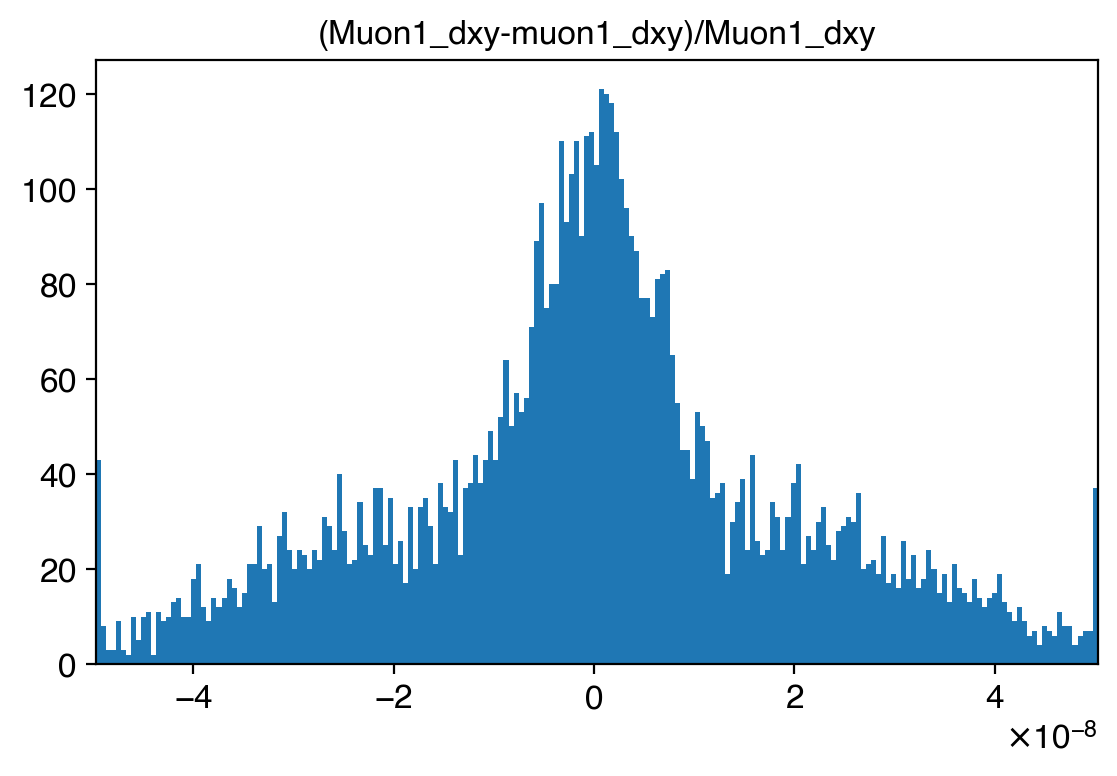

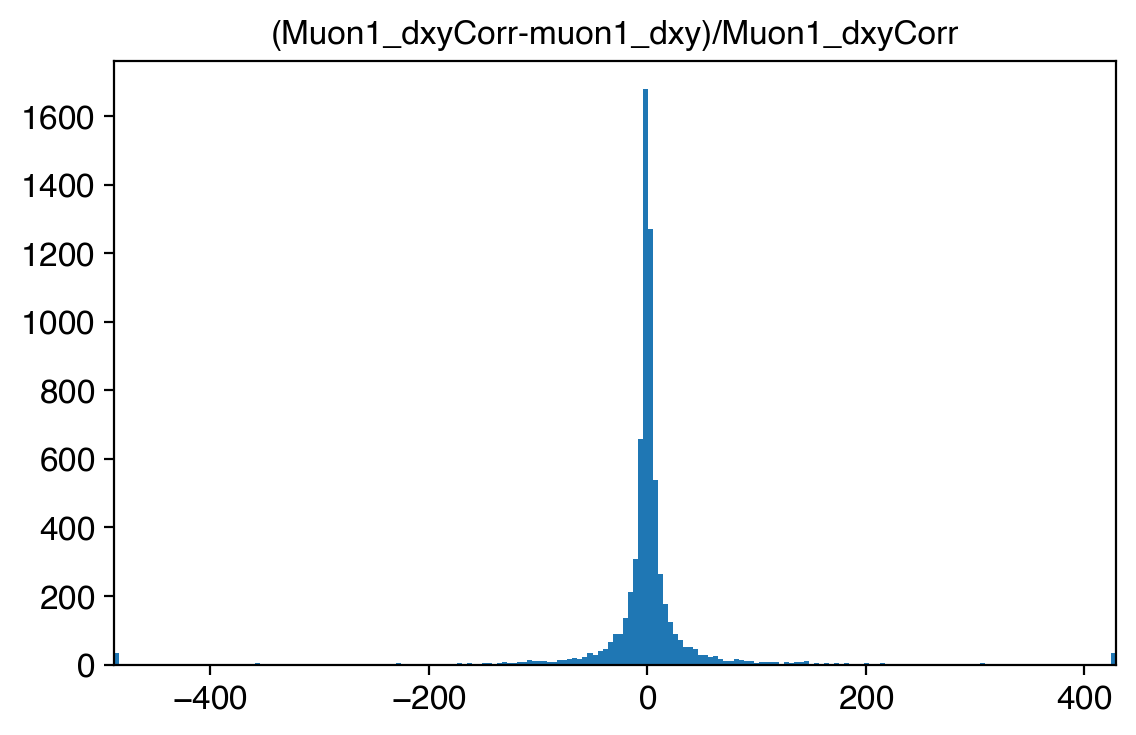

In [122]:
def compare(x,y):
    fracdiffs = (x-y) / x
    fig, ax = plt.subplots()
    low = fracdiffs.quantile(0.005)
    high = fracdiffs.quantile(0.995)
    h = Hist1D(fracdiffs, bins=np.linspace(low,high,200))
#     h = Hist1D(fracdiffs, bins=np.linspace(-0.0025,0.0025))
    h.plot(ax=ax)
    ax.set_title(f"({x.name}-{y.name})/{x.name}")
    
#     print(fracdiffs)
    
dfm["lxy_test"] = dfm.eval("((DV_x-PVM_x)**2 + (DV_y-PVM_y)**2)**0.5")

# compare("lxy_s","lxy_r")
# compare("PVM_y","PVy")
# compare("DV_rhoCorr","lxy_r")
# compare(dfm[,"lxy_r")
compare(dfm["Muon1_dxy"],dfm["muon1_dxy"])
compare(dfm["Muon1_dxyCorr"],dfm["muon1_dxy"])
# compare("DV_x","DVx")

In [123]:
dfm["lxy_r"].name

'lxy_r'

In [124]:
dfs[["run","luminosityBlock","BS_x","BS_y","PVM_x","PVM_y"]].drop_duplicates()

,run,luminosityBlock,BS_x,BS_y,PVM_x,PVM_y
0,302033,1,0.084806,-0.031721,0.083577,-0.031439
1,302033,1,0.084806,-0.031721,0.084468,-0.031705
2,302033,1,0.084806,-0.031721,0.084444,-0.031698
3,302033,1,0.084806,-0.031721,0.083935,-0.031546
4,302033,1,0.084806,-0.031721,0.083923,-0.031542
...,...,...,...,...,...,...
6764,302033,39,0.084806,-0.031721,0.083803,-0.031569
6765,302033,39,0.084806,-0.031721,0.084147,-0.031579
6766,302033,39,0.084806,-0.031721,0.084195,-0.031625
6767,302033,39,0.084806,-0.031721,0.083566,-0.031448


In [129]:
fname = "/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v10/output_1.root"
dfmc = make_df(fname, haslxy=False)
# df = dfmc

# data
df = dfs


(37030,)
34404


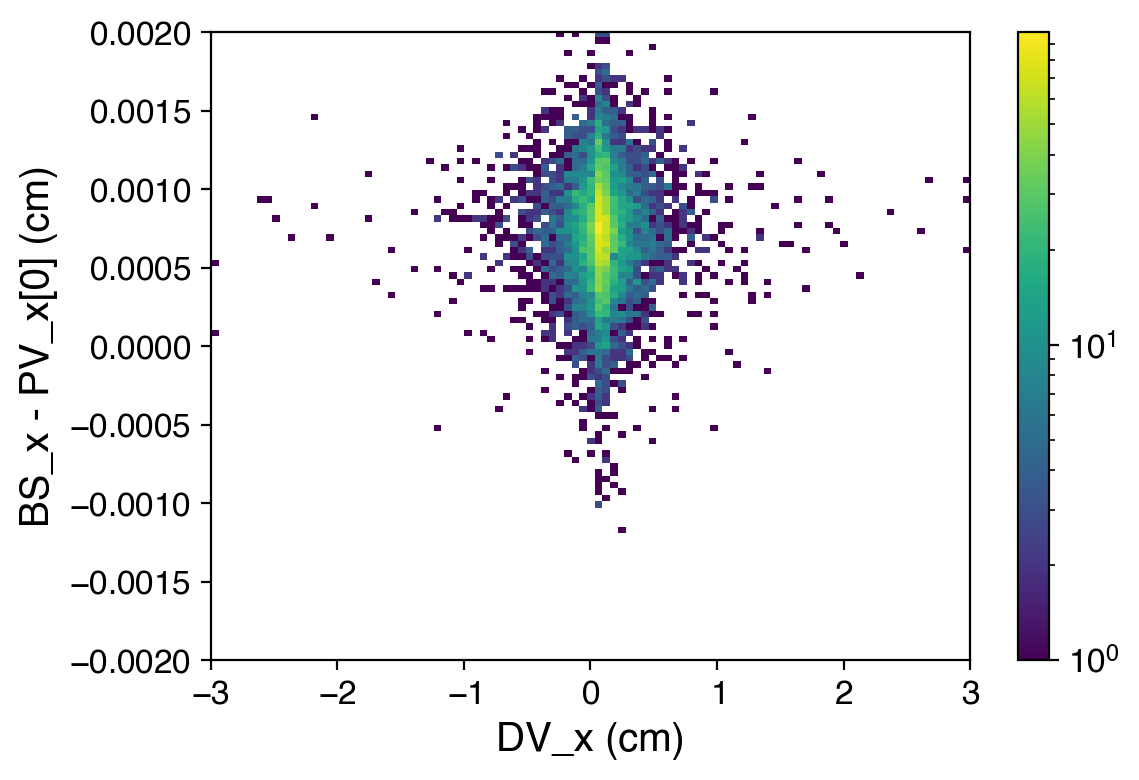

In [131]:
# bins = [np.linspace(-11,11,100),np.linspace(-1e-4,1e-4,100)]
bins = [np.linspace(-3,3,100),np.linspace(-2e-3,2e-3,100)]

# bins = [np.linspace(-11,11,100),np.linspace(0.01050,0.011,100)]

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
# fig, ax = plt.subplots(1,1,figsize=(4,4))
fig, ax = plt.subplots()
h = Hist2D(np.c_[
    df["DV_x"],
    (df["BS_x"]-df["PVM_x"])*1e0,
#     (df["PVM_x"])*1e0,
    ],bins=bins)
# h.plot(ax=ax1, logz=True)
h.plot(ax=ax, logz=True)

# h = Hist2D(np.c_[
#     df["DV_y"],
#     (df["BS_y"]-df["PVM_y"])*1e0,
#     ],bins=bins)
# h.plot(ax=ax2, logz=True)

ax.set_ylabel("BS_x - PV_x[0] (cm)")
ax.set_xlabel("DV_x (cm)")

# ax1.set_ylabel("BS_x - PV_x[0] (cm)")
# ax2.set_ylabel("BS_y - PV_y[0] (cm)")
# ax1.set_xlabel("DV_x (cm)")
# ax2.set_xlabel("DV_y (cm)")

fig.set_tight_layout(True)